In [1]:
!pip install -q seaborn

In [2]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.0.0


In [3]:
dataset_path = keras.utils.get_file('auto-mpg.data', 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
dataset_path

'/home/lukec/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, 
                          names=column_names,
                          na_values='?',
                          comment='\t',
                          sep=' ',
                          skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.size

3184

In [6]:
# detecting unknown value
isna = dataset.isna()
isna.sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
isna[isna['Horsepower']==True]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
32,False,False,False,True,False,False,False,False
126,False,False,False,True,False,False,False,False
330,False,False,False,True,False,False,False,False
336,False,False,False,True,False,False,False,False
354,False,False,False,True,False,False,False,False
374,False,False,False,True,False,False,False,False


In [8]:
print(dataset.shape)
print(isna[isna['Horsepower']!=True].shape)

(398, 8)
(392, 8)


In [9]:
# drop 6 rows which contain unkown Horsepower
dataset = dataset.dropna()

In [10]:
dataset.shape

(392, 8)

In [11]:
# convert categorical column into one-hot encoding
# origin = dataset.pop('Origin')
# dataset['USA'] = (origin == 1) * 1.0
# dataset['Europe'] = (origin == 2) * 1.0
# dataset['Japan'] = (origin == 3) * 1.0

dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))
#Convert categorical variable into dummy/indicator variables
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')

In [12]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [13]:
# Split training and test data
train_set = dataset.sample(frac=0.8, random_state=0)
test_set = dataset.drop(train_set.index)

In [14]:
print(train_set.shape)
print(test_set.shape)

(314, 10)
(78, 10)


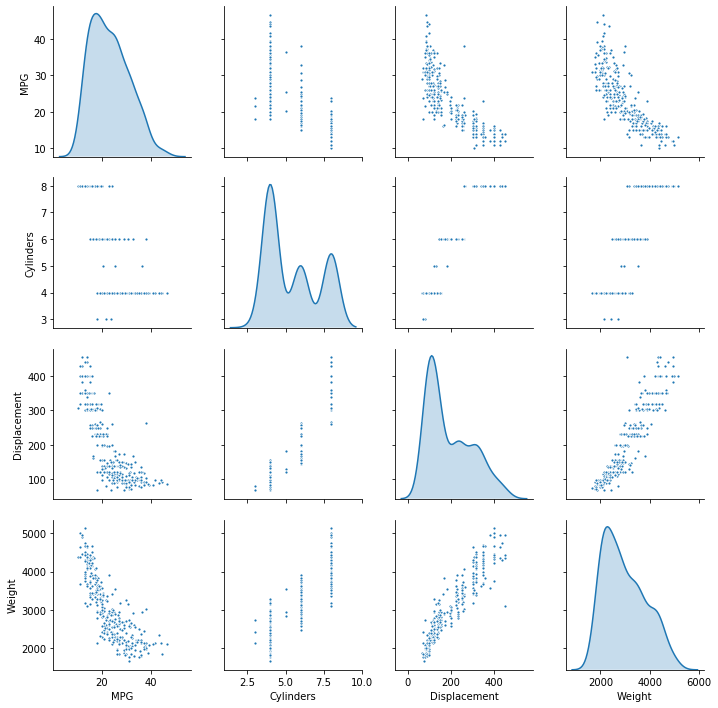

In [15]:
# KDE: kernel density estimation - histogram plots
sns.pairplot(train_set[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde', markers='.')

In [16]:
train_stats = train_set.describe()
# remove Y
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [17]:
# get target labels
train_Y = train_set.pop('MPG')
test_Y = test_set.pop('MPG')
print(train_Y.shape)
print(test_Y.shape)

(314,)
(78,)


In [19]:
train_Y.tail()

281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, dtype: float64

In [20]:
# Normalize the data
def norm(X):
    return (X - train_stats['mean']) / train_stats['std']

In [21]:
normed_train_set = norm(train_set)
normed_test_set = norm(test_set)

## Build model

In [23]:
print(train_set.keys())
print(len(train_set.keys()))

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Europe', 'Japan', 'USA'],
      dtype='object')
9


In [27]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=[len(train_set.keys())]),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    
    return model

In [28]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [30]:
example_batch = normed_train_set[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.19189626],
       [-0.03100323],
       [ 0.01352326],
       [-0.18118013],
       [ 0.10983732],
       [ 0.05329346],
       [ 0.06381459],
       [ 0.00038041],
       [-0.01649532],
       [ 0.3499694 ]], dtype=float32)

In [31]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [32]:
EPOCHS = 1000

In [34]:
history = model.fit(
  normed_train_set, train_Y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [35]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.662652,1.050916,2.662652,8.985978,2.265186,8.985977,995
996,2.605698,1.025420,2.605698,9.255006,2.309977,9.255005,996
997,2.683517,1.061814,2.683517,9.473239,2.383879,9.473240,997
998,2.689697,1.063832,2.689697,9.647603,2.302588,9.647602,998
999,2.577495,1.044835,2.577495,9.109559,2.304533,9.109559,999


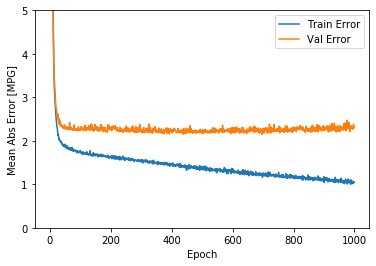

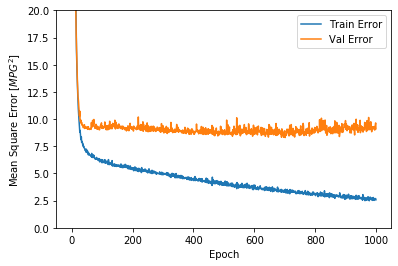

In [37]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)